In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nixtla.experiments.utils import *
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from nixtla.losses.numpy import mae, mape, smape, rmse, pinball_loss

# Data

In [2]:
data = pd.read_csv('../data/healthcare/data_icu.csv')
data.head()

,unique_id,ds,HR,RR,SPO2
0,20200307_1388015_1984173,64909.320,89.0,22.0,91.9
1,20200307_1388015_1984173,64910.344,89.0,22.0,91.8
2,20200307_1388015_1984173,64911.368,91.0,22.0,91.6
3,20200307_1388015_1984173,64912.392,90.0,23.0,91.6
4,20200307_1388015_1984173,64913.416,97.0,23.0,91.5


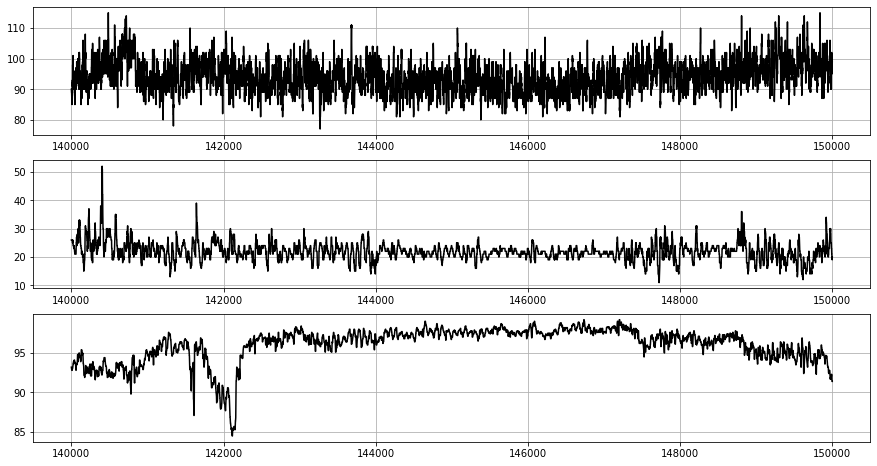

In [3]:
unique_patients = data.unique_id.unique()
patient_id = 14
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (15,8))
ax[0].plot(data[data['unique_id']==unique_patients[patient_id]]['HR'], c='black')
ax[0].grid()
ax[1].plot(data[data['unique_id']==unique_patients[patient_id]]['RR'], c='black')
ax[1].grid(True)
ax[2].plot(data[data['unique_id']==unique_patients[patient_id]]['SPO2'], c='black')
ax[2].grid(True)

In [4]:
mini = data[['unique_id','ds']].groupby('unique_id').min()
maxi = data[['unique_id','ds']].groupby('unique_id').max()
hola = mini.merge(maxi, on='unique_id').reset_index(drop=False)
hola['ds_y']-hola['ds_x']

0      8679.424
1     10241.024
2     10244.096
3     10243.072
4     10235.904
5     10238.976
6     10241.024
7     10238.976
8     10242.048
9      8717.312
10    10238.976
11    10241.024
12    10240.544
13    10242.048
14    10272.049
15    10240.000
16    10271.026
17    10271.205
18    10268.977
dtype: float64

# Model

In [5]:
nbeats_space= {# Architecture parameters
               'model':'nbeats',
               'input_size_multiplier': hp.choice('input_size_multiplier', [1, 2, 3, 4, 5]),
               'output_size': hp.choice('output_size', [120]),
               'shared_weights': hp.choice('shared_weights', [False]),
               'activation': hp.choice('activation', ['relu','selu']),
               'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
               'stack_types': hp.choice('stack_types', [ 5*['identity'] ]),
               'n_blocks': hp.choice('n_blocks', [ 5*[1] ]),
               'n_layers': hp.choice('n_layers', [ 5*[2] ]),
               'n_hidden': hp.choice('n_hidden', [ 512 ]),
               'n_harmonics': hp.choice('n_harmonics', [2]),
               'n_polynomials': hp.choice('n_polynomials', [4]),
               'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
               'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
               # Regularization and optimization parameters
               'batch_normalization': hp.choice('batch_normalization', [False, True]),
               'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 0.5),
               'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
               'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
               'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
               'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
               'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
               'n_iterations': hp.choice('n_iterations', [1_000]), #[args.max_epochs]),
               'early_stopping': hp.choice('early_stopping', [10]),
               'eval_freq': hp.choice('eval_freq', [50]),
               'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
               'loss': hp.choice('loss', ['MAE', 'MSE']),
               'loss_hypar': hp.choice('loss_hypar', [0.5]),                
               'val_loss': hp.choice('val_loss', ['MAE']), #[args.val_loss]),
               'l1_theta': hp.choice('l1_theta', [0]),
               # Data parameters
               'len_sample_chunks': hp.choice('len_sample_chunks', [None]),
               'normalizer_y': hp.choice('normalizer_y', [None]),
               'normalizer_x': hp.choice('normalizer_x', [None]),
               'window_sampling_limit': hp.choice('window_sampling_limit', [100_000]),
               'complete_inputs': hp.choice('complete_inputs', [True]),
               'complete_sample': hp.choice('complete_sample', [True]),                
               'frequency': hp.choice('frequency', ['H']),
               'seasonality': hp.choice('seasonality', [24]),      
               'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
               'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
               'batch_size': hp.choice('batch_size', [256]),
               'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
               'random_seed': hp.quniform('random_seed', 10, 20, 1)}

In [6]:
Y_df = data[['unique_id','ds','HR']]
#Y_df = Y_df[Y_df['unique_id']==unique_patients[patient_id]].reset_index(drop=True)
#Y_df = Y_df[Y_df['unique_id'].isin(unique_patients[:1])].reset_index(drop=True)
Y_df = Y_df.sort_values(['unique_id','ds']).reset_index(drop=True)
Y_df = Y_df.rename(columns={'HR':'y'})
Y_df['ds'] = np.tile(np.array(range(10000)), 19)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df

,unique_id,ds,y
0,20190702_1278157_1351043,1970-01-01 00:00:00.000000000,76.0
1,20190702_1278157_1351043,1970-01-01 00:00:00.000000001,76.0
2,20190702_1278157_1351043,1970-01-01 00:00:00.000000002,76.0
3,20190702_1278157_1351043,1970-01-01 00:00:00.000000003,76.0
4,20190702_1278157_1351043,1970-01-01 00:00:00.000000004,76.0
...,...,...,...
189995,20210316_1198186_1331485,1970-01-01 00:00:00.000009995,79.0
189996,20210316_1198186_1331485,1970-01-01 00:00:00.000009996,80.0
189997,20210316_1198186_1331485,1970-01-01 00:00:00.000009997,80.0
189998,20210316_1198186_1331485,1970-01-01 00:00:00.000009998,81.0


In [7]:
trials = hyperopt_tunning(space=nbeats_space, hyperopt_iters=10, loss_function=mae, Y_df=Y_df, X_df=None, S_df=None,
                          ds_in_test=120, shuffle_outsample=False)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]WARNING:root:Batch size will be ignored (shuffle=False). All windows constructed will be used to train.

============================== Start fitting ==============================
Step: 50, Time: 7.443, Insample MAE: 2.99563, Outsample MAE: 4.75340
Step: 100, Time: 14.939, Insample MAE: 3.39459, Outsample MAE: 4.78348
Step: 150, Time: 22.407, Insample MAE: 1.65899, Outsample MAE: 5.42682
Step: 200, Time: 29.920, Insample MAE: 1.72773, Outsample MAE: 12.16249
Step: 250, Time: 37.421, Insample MAE: 5.52321, Outsample MAE: 4.70374
Step: 300, Time: 44.723, Insample MAE: 3.26919, Outsample MAE: 4.67626
Step: 350, Time: 52.009, Insample MAE: 2.22819, Outsample MAE: 6.05077
Step: 400, Time: 59.341, Insample MAE: 1.42461, Outsample MAE: 4.38401
Step: 450, Time: 66.717, Insample MAE: 1.24224, Outsample MAE: 5.61019
Step: 500, Time: 74.171, Insample MAE: 2.19084, Outsample MAE: 8.22520
Step: 550, Time: 81.547, Insample MAE: 1.57318, Outsampl

In [8]:
y_hat = trials.trials[0]['result']['y_hat']
y_true = trials.trials[0]['result']['y_true']

In [9]:
y_hat.shape

(19, 1, 120)

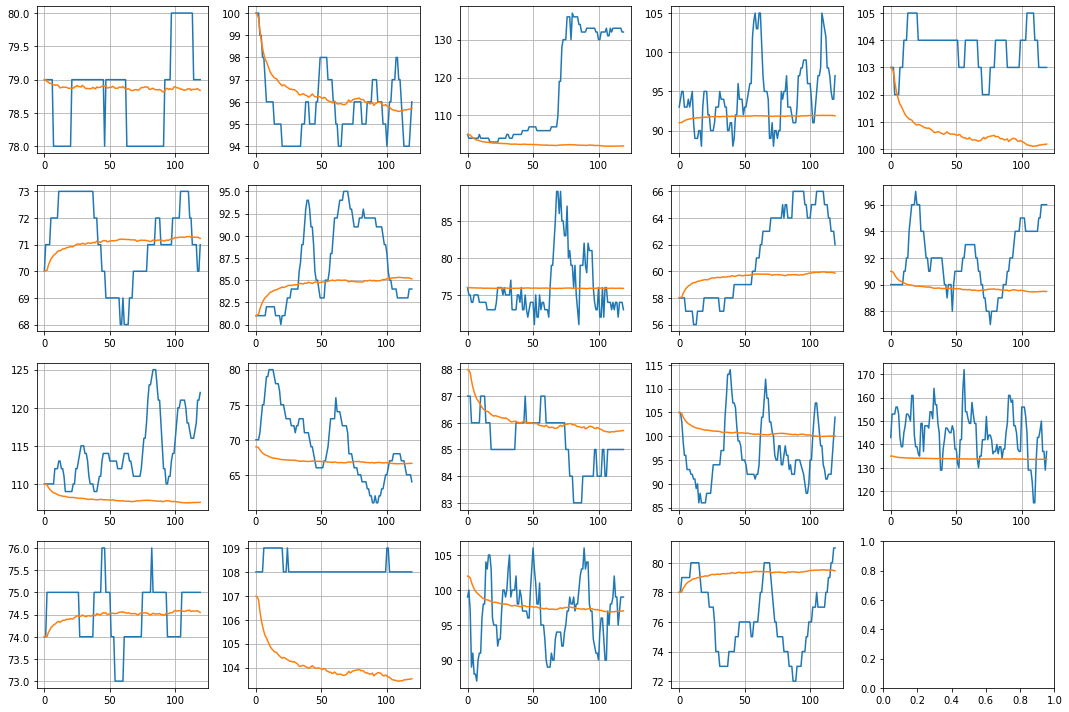

In [10]:
unique_patients = data.unique_id.unique()
fig, ax = plt.subplots(nrows=4, ncols=5, figsize = (15,10))
for i in range(19):
    ax[i//5, i%5].plot(y_true[i,0,:])
    ax[i//5, i%5].plot(y_hat[i,0,:])
    ax[i//5, i%5].grid(True)
plt.tight_layout()